In [1]:
# FNG ITER Neutron Streaming Benchmark postprocessing

In [3]:
# import modules
import openmc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("ticks")

In [3]:
# parameters & functions
# sns.set_style('darkgrid')
# dect_vol =  # cm3 - detector cells volume

def read_measured_data(data_filename, sheet_name):
    df = pd.read_excel(data_filename, sheet_name=sheet_name)
    df[['y (cm)', 'E', 'Error on E']] = df['y (cm)      E      Error on E'].str.split('     ', 2, expand=True)
    df = df.iloc[:, 1:]
    try:
        df[:] = df[:].astype(float)
        df['Error on E'] = df['Error on E']*df['E']/100
    except (ValueError, TypeError):
        pass

    return df

def read_measured_data_wpos(data_filename, sheet_name):
    df = pd.read_excel(data_filename, sheet_name=sheet_name)
    df[['Position/y (cm)', 'E', 'Error on E']] = df['Position/y (cm)     E     Error on E'].str.split('    ', 2, expand=True)
    df = df.iloc[:, 1:]
    for column in df:
        try:
            df[column] = df[column].astype(float)
        except (ValueError, TypeError):
            pass
    
    try:
        df['Error on E'] = df['Error on E']*df['E']/100
    except (ValueError, TypeError):
        pass
    
    return df

def read_computed_data(data_filename, sheet_name):
    df = pd.read_excel(data_filename, sheet_name=sheet_name)
    df[['y(cm)', 'C EFF-3', 'EFF-3 err', 'C FENDL-1', 'FENDL-1 err', 'C FENDL-2', 'FENDL-2 err', 'C/E EFF-3', 'C/E FEN-1', 'C/E FEN-2']] = df['y(cm)     C EFF-3     EFF-3 err     C FENDL-1     FENDL-1 err     C FENDL-2     FENDL-2 err     C/E EFF-3     C/E FEN-1     C/E FEN-2'].str.split('     ', 10, expand=True)
    df = df.iloc[:, 1:]

    for column in df:
        try:
            df[column] = df[column].astype(float)
        except (ValueError, TypeError):
            pass

    try:
        df['EFF-3 err'] = df['EFF-3 err']*df['C EFF-3']/100
        df['FENDL-1 err'] = df['FENDL-1 err']*df['C FENDL-1']/100
        df['FENDL-2 err'] = df['FENDL-2 err']*df['C FENDL-2']/100
    except (ValueError, TypeError):
        pass

    return df

def read_computed_data2(data_filename, sheet_name):
    df = pd.read_excel(data_filename, sheet_name=sheet_name)
    df[['y(cm)', 'C EFF-3', 'EFF-3 err', 'C FENDL-1', 'FENDL-1 err', 'C/E EFF-3', 'C/E FEN-1']] = df['y(cm)     C EFF-3     EFF-3 err     C FENDL-1     FENDL-1 err     C/E EFF-3     C/E FEN-1'].str.split('     ', 7, expand=True)
    df = df.iloc[:, 1:]

    for column in df:
        try:
            df[column] = df[column].astype(float)
        except (ValueError, TypeError):
            pass
    
    try:
        df['EFF-3 err'] = df['EFF-3 err']*df['C EFF-3']/100
        df['FENDL-1 err'] = df['FENDL-1 err']*df['C FENDL-1']/100
    except (ValueError, TypeError):
        pass

    return df

def read_computed_data_wpos(data_filename, sheet_name):
    df = pd.read_excel(data_filename, sheet_name=sheet_name)
    df[['Position/y(cm)', 'C EFF-3', 'EFF-3 err', 'C FENDL-1', 'FENDL-1 err', 'C FENDL-2', 'FENDL-2 err', 'C/E EFF-3', 'C/E FEN-1', 'C/E FEN-2']] = df['Position/y(cm)     C EFF-3     EFF-3 err     C FENDL-1     FENDL-1 err     C FENDL-2     FENDL-2 err     C/E EFF-3     C/E FEN-1     C/E FEN-2'].str.split('     ', 10, expand=True)
    df = df.iloc[:, 1:]
    for column in df:
        try:
            df[column] = df[column].astype(float)
        except (ValueError, TypeError):
            pass
    
    try:
        df['EFF-3 err'] = df['EFF-3 err']*df['C EFF-3']/100
        df['FENDL-1 err'] = df['FENDL-1 err']*df['C FENDL-1']/100
        df['FENDL-2 err'] = df['FENDL-2 err']*df['C FENDL-2']/100
    except (ValueError, TypeError):
        pass

    return df

def read_computed_data_wpos2(data_filename, sheet_name):
    df = pd.read_excel(data_filename, sheet_name=sheet_name)
    df[['Position/y(cm)', 'C EFF-3', 'EFF-3 err', 'C FENDL-1', 'FENDL-1 err', 'C/E EFF-3', 'C/E FEN-1']] = df['Position/y(cm)     C EFF-3     EFF-3 err     C FENDL-1     FENDL-1 err     C/E EFF-3     C/E FEN-1'].str.split('     ', 7, expand=True)
    df = df.iloc[:, 1:]
    
    for column in df:
        try:
            df[column] = df[column].astype(float)
        except (ValueError, TypeError):
            pass
    
    try:
        df['EFF-3 err'] = df['EFF-3 err']*df['C EFF-3']/100
        df['FENDL-1 err'] = df['FENDL-1 err']*df['C FENDL-1']/100
    except (ValueError, TypeError):
        pass

    return df

In [4]:
# MEASURED REACTION RATE RESULTS (from the "fnsstr-a.htm" file in SINBAD)

reactions = [r'Nb93n2n', r'Al27na', r'Ni58np', r'Au197ng']

#  Table 5: Experimental results (E) of reaction rates measurements along the central mock-up axis, 
# with the neutron source on axis with respect to the channel/box structure (IN-AXIS) (1.0E-24/source neutron)
tab5_measured_nb = read_measured_data(r'tab5_reaction_rates.xlsx', reactions[0])
tab5_measured_al = read_measured_data(r'tab5_reaction_rates.xlsx', reactions[1])
tab5_measured_ni = read_measured_data(r'tab5_reaction_rates.xlsx', reactions[2])
tab5_measured_au = read_measured_data(r'tab5_reaction_rates.xlsx', reactions[3])
# Table 6: Experimental results (E) of reaction rates measurements inside the cavity, 
# with the neutron source on axis with respect to the channel/cavity structure (IN-AXIS)(1.0E-24/source neutron)
tab6_measured_nb = read_measured_data_wpos(r'tab6_reaction_rates.xlsx', reactions[0])
tab6_measured_al = read_measured_data_wpos(r'tab6_reaction_rates.xlsx', reactions[1])
tab6_measured_ni = read_measured_data_wpos(r'tab6_reaction_rates.xlsx', reactions[2])
tab6_measured_au = read_measured_data_wpos(r'tab6_reaction_rates.xlsx', reactions[3])
# Table 7: Experimental results (E) of reaction rates measurements in the channel and in the cavity, 
# with the neutron source shifted with respect to the channel/cavity axis (OFF-AXIS) (1.0E-24/source neutron)
tab7_measured_nb = read_measured_data_wpos(r'tab7_reaction_rates.xlsx', reactions[0])
tab7_measured_al = read_measured_data_wpos(r'tab7_reaction_rates.xlsx', reactions[1])
tab7_measured_ni = read_measured_data_wpos(r'tab7_reaction_rates.xlsx', reactions[2])
tab7_measured_au = read_measured_data_wpos(r'tab7_reaction_rates.xlsx', reactions[3])


In [5]:
# MCNP COMPUTED REACTION RATE RESULTS (from the "fnsstr-a.htm" file in SINBAD)
# Tab. 9 : Calculated reaction rates (C) along the central mock-up axis  obtained using  MCNP
# with FENDL-1, FENDL-2 and EFF-3 nuclear data libraries (1.0E-24/source neutron). 
# Errors represent MCNP calculation statistical uncertainties.  
# Comparison between calculated and measured values (C/E ratios) (ON-AXIS) 
tab9_computed_nb = read_computed_data(r'tab9_reaction_rates.xlsx', reactions[0])
tab9_computed_al = read_computed_data(r'tab9_reaction_rates.xlsx', reactions[1])
tab9_computed_ni = read_computed_data(r'tab9_reaction_rates.xlsx', reactions[2])
tab9_computed_au = read_computed_data2(r'tab9_reaction_rates.xlsx', reactions[3])
# Tab. 10 : Calculated reaction rates (C) in the cavity obtained using MCNP
# with FENDL-1/FENDL-2 and EFF-3 nuclear data libraries (1.0E-24/source neutron). 
# Errors represent the MCNP calculation statistical uncertainties. 
# Comparison between calculated and measured values (C/E ratios)
tab10_computed_nb = read_computed_data_wpos(r'tab10_reaction_rates.xlsx', reactions[0])
tab10_computed_al = read_computed_data_wpos(r'tab10_reaction_rates.xlsx', reactions[1])
tab10_computed_ni = read_computed_data_wpos(r'tab10_reaction_rates.xlsx', reactions[2])
tab10_computed_au = read_computed_data_wpos2(r'tab10_reaction_rates.xlsx', reactions[3])
# Tab. 11 : Calculated reaction rates (C) in the channel and in the cavity obtained using MCNP
# with FENDL-1/FENDL-2 and EFF-3 nuclear data libraries (1.0E-24/source neutron). 
# Errors represent the MCNP calculation statistical uncertainties. 
# Comparison between calculated and measured values (C/E ratios) (OFF-AXIS)
tab11_computed_nb = read_computed_data_wpos(r'tab11_reaction_rates.xlsx', reactions[0])
tab11_computed_al = read_computed_data_wpos(r'tab11_reaction_rates.xlsx', reactions[1])
tab11_computed_ni = read_computed_data_wpos(r'tab11_reaction_rates.xlsx', reactions[2])
tab11_computed_au = read_computed_data_wpos2(r'tab11_reaction_rates.xlsx', reactions[3])

In [6]:
# read results from OpenMC simulations

# ON-AXIS results
omc_sp_nb = openmc.StatePoint('statepoint_nb1b.10.h5')
omc_sp_al = openmc.StatePoint('statepoint_al1b.10.h5')
omc_sp_ni = openmc.StatePoint('statepoint_ni1b.10.h5')
omc_sp_au = openmc.StatePoint('statepoint.10.h5')

detector_reaction_rate_nb = omc_sp_nb.get_tally(name='detector_reaction_rate').get_pandas_dataframe()
detector_reaction_rate_al = omc_sp_al.get_tally(name='detector_reaction_rate').get_pandas_dataframe()
detector_reaction_rate_ni = omc_sp_ni.get_tally(name='detector_reaction_rate').get_pandas_dataframe()
detector_reaction_rate_au = omc_sp_au.get_tally(name='detector_reaction_rate').get_pandas_dataframe()

omc_nb = detector_reaction_rate_nb.loc[(detector_reaction_rate_nb['nuclide'] == 'Nb93') & (detector_reaction_rate_nb['score'] == '(n,2n)')]
omc_al = detector_reaction_rate_al.loc[(detector_reaction_rate_al['nuclide'] == 'Al27') & (detector_reaction_rate_al['score'] == '(n,a)')]
omc_ni = detector_reaction_rate_ni.loc[(detector_reaction_rate_ni['nuclide'] == 'Ni58') & (detector_reaction_rate_ni['score'] == '(n,p)')]
omc_au = detector_reaction_rate_au.loc[(detector_reaction_rate_au['nuclide'] == 'Au197') & (detector_reaction_rate_au['score'] == '(n,gamma)')]


In [7]:
# OFF-AXIS results
omc_sp_nb_oa = openmc.StatePoint('statepoint_nb500k_offaxis.10.h5')
omc_sp_al_oa = openmc.StatePoint('statepoint_al500k_offaxis.10.h5')
omc_sp_ni_oa = openmc.StatePoint('statepoint_ni1b_offaxis.10.h5')
omc_sp_au_oa = openmc.StatePoint('statepoint_au500k_offaxis.10.h5')

detector_reaction_rate_nb_oa = omc_sp_nb_oa.get_tally(name='detector_reaction_rate').get_pandas_dataframe()
detector_reaction_rate_al_oa = omc_sp_al_oa.get_tally(name='detector_reaction_rate').get_pandas_dataframe()
detector_reaction_rate_ni_oa = omc_sp_ni_oa.get_tally(name='detector_reaction_rate').get_pandas_dataframe()
detector_reaction_rate_au_oa = omc_sp_au_oa.get_tally(name='detector_reaction_rate').get_pandas_dataframe()

omc_nb_oa = detector_reaction_rate_nb_oa.loc[(detector_reaction_rate_nb_oa['nuclide'] == 'Nb93') & (detector_reaction_rate_nb_oa['score'] == '(n,2n)')]
omc_al_oa = detector_reaction_rate_al_oa.loc[(detector_reaction_rate_al_oa['nuclide'] == 'Al27') & (detector_reaction_rate_al_oa['score'] == '(n,a)')]
omc_ni_oa = detector_reaction_rate_ni_oa.loc[(detector_reaction_rate_ni_oa['nuclide'] == 'Ni58') & (detector_reaction_rate_ni_oa['score'] == '(n,p)')]
omc_au_oa = detector_reaction_rate_au_oa.loc[(detector_reaction_rate_au_oa['nuclide'] == 'Au197') & (detector_reaction_rate_au_oa['score'] == '(n,gamma)')]

In [8]:
# selecting cell for different tables:
table9_cell_x = [135, 158, 181, 204, 602, 239, 262, 285, 308, 331, 363, 386, 398]
table9_cell_au = [602, 239, 262, 285, 308, 331, 363, 386]
table10_cell_x = table10_cell_au = [605, 606, 607, 608, 609, 610, 611, 612, 602, 603, 604]
table11_cell_x = [135, 158, 181, 204, 605, 606, 607, 608, 609, 610, 611, 612, 602, 603, 604]
table11_cell_au = [605, 606, 607, 608, 609, 610, 611, 612, 602, 603, 604]

#
omc_tab9_nb = omc_nb[omc_nb['cell'].isin(table9_cell_x)]
omc_tab10_nb = omc_nb[omc_nb['cell'].isin(table10_cell_x)]
omc_tab11_nb = omc_nb_oa[omc_nb_oa['cell'].isin(table11_cell_x)]
#
omc_tab9_al = omc_al[omc_al['cell'].isin(table9_cell_x)]
omc_tab10_al = omc_al[omc_al['cell'].isin(table10_cell_x)]
omc_tab11_al = omc_al_oa[omc_al_oa['cell'].isin(table11_cell_x)]
#
omc_tab9_ni = omc_ni[omc_ni['cell'].isin(table9_cell_x)]
omc_tab10_ni = omc_ni[omc_ni['cell'].isin(table10_cell_x)]
omc_tab11_ni = omc_ni_oa[omc_ni_oa['cell'].isin(table11_cell_x)]
#
omc_tab9_au = omc_au[omc_au['cell'].isin(table9_cell_au)]
omc_tab10_au = omc_au[omc_au['cell'].isin(table10_cell_au)]
omc_tab11_au = omc_au_oa[omc_au_oa['cell'].isin(table11_cell_au)]


In [9]:
# reaction rate multiplication coefficients for reaction/1e24 atoms
# for instance: 
# nb atom density = 0.1204 atoms / b-cm
# nb act foil volume = 0.2545 or 0.509 or 0.7635 e24 b*cm, depending on the position in the mockup
# coeff for nb in low depts: 1 / (0.1204*0.2545) = 32.6352
# also, ni58 has 68.27% abundance

# actual density
tab9_nb_coeff = np.array([1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545/2, 1/0.2545/2, 1/0.2545/2, 1/0.2545/2, 1/0.2545/3, 1/0.2545/3, 1/0.2545/3, 1/0.2545/3]) / 0.05555
tab9_al_coeff = np.array([1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545/2, 1/0.2545/2, 1/0.2545/2, 1/0.2545/2, 1/0.2545/3, 1/0.2545/3, 1/0.2545/3, 1/0.2545/3]) / 0.06026
tab9_ni_coeff = np.array([1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545/2, 1/0.2545/2, 1/0.2545/2, 1/0.2545/2, 1/0.2545/3, 1/0.2545/3, 1/0.2545/3, 1/0.2545/3]) / 0.06222
tab9_au_coeff = np.array([1/0.2545, 1/0.2545/2, 1/0.2545/2, 1/0.2545/2, 1/0.2545/2, 1/0.2545/3, 1/0.2545/3, 1/0.2545/3]) / 0.05901 / 0.005

tab10_nb_coeff = np.ones(11) / 0.2545 /  0.05555
tab10_al_coeff = np.ones(11) / 0.2545 / 0.06026
tab10_ni_coeff = np.ones(11) / 0.2545 / 0.06222
tab10_au_coeff = np.ones(11) / 0.2545 / 0.05901 / 0.005

tab11_nb_coeff = np.array([1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545]) / 0.05555
tab11_al_coeff = np.array([1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545]) / 0.06026
tab11_ni_coeff = np.array([1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545]) / 0.06222
tab11_au_coeff = np.array([1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545, 1/0.2545]) / 0.05901 / 0.005

In [10]:
# error propagation

np.arange(len(tab5_measured_nb)), tab5_measured_nb['E'], tab5_measured_nb['Error on E']
np.arange(len(tab9_computed_nb)), tab9_computed_nb['C FENDL-1'], tab9_computed_nb['FENDL-1 err']

mcnp_ce_ni = np.array(tab9_computed_ni['C FENDL-1']) / np.array(tab5_measured_ni['E'])
mcnp_ce_err_ni = mcnp_ce_ni * np.sqrt((np.array(tab5_measured_nb['Error on E'])/np.array(tab5_measured_nb['E']))**2 + (np.array(tab9_computed_nb['FENDL-1 err'])/np.array(tab9_computed_nb['C FENDL-1']))**2)
omc_ce_ni = np.array(omc_tab9_ni['mean']) * tab9_ni_coeff / np.array(tab5_measured_ni['E'])
omc_ce_err_ni = omc_ce_ni * np.sqrt((np.array(tab5_measured_nb['Error on E'])/np.array(tab5_measured_nb['E']))**2 + (np.array(omc_tab9_nb['std. dev.'])/np.array(omc_tab9_nb['mean']))**2)


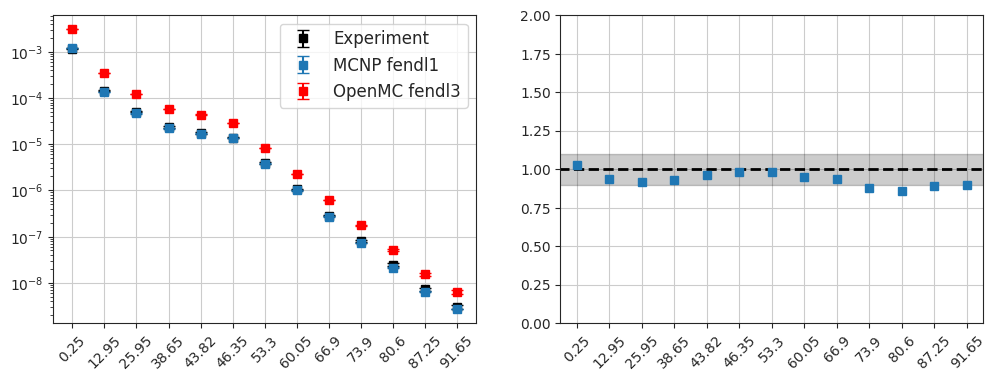

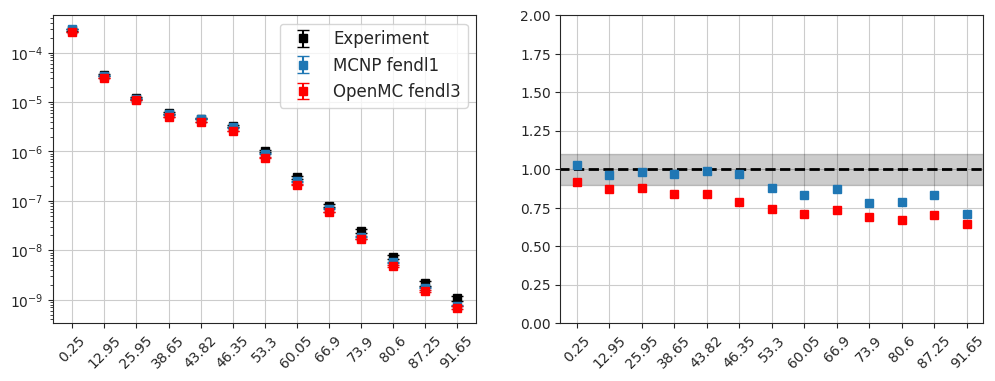

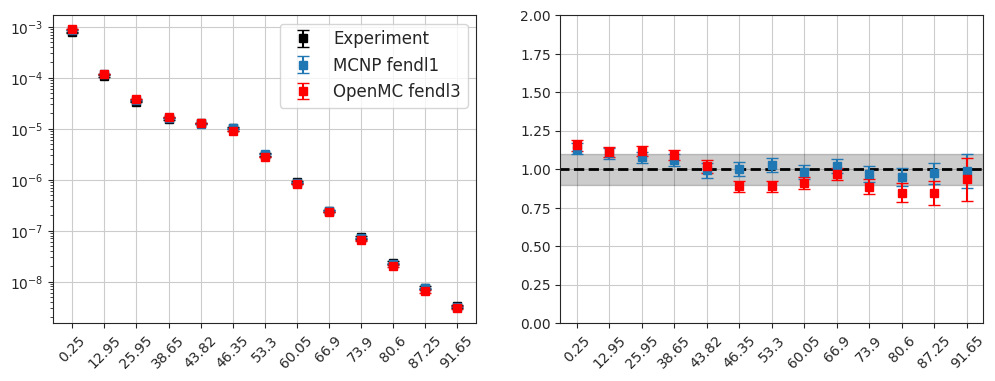

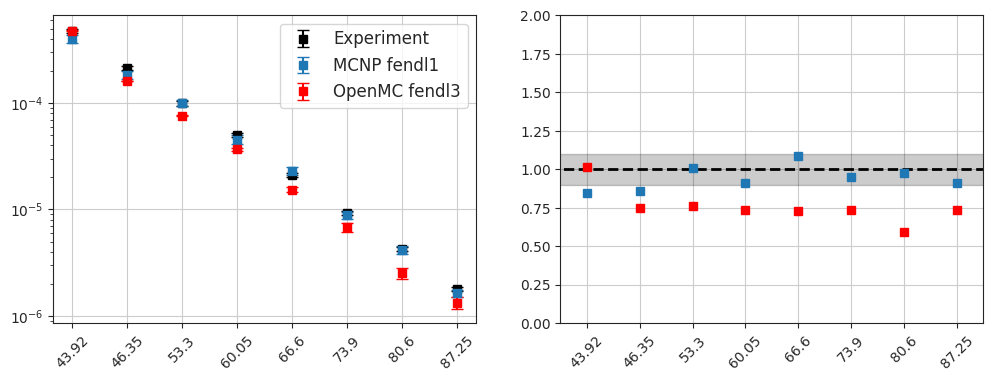

In [11]:
# Tables 5 and 9 results

# Nb93(n,2n)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax1.errorbar(np.arange(len(tab5_measured_nb)), tab5_measured_nb['E'], tab5_measured_nb['Error on E'], marker='s', ms=6, ls='none', capsize=4, color='k', label='Experiment')
ax1.errorbar(np.arange(len(tab9_computed_nb)), tab9_computed_nb['C FENDL-1'], tab9_computed_nb['FENDL-1 err'], marker='s', ms=6, ls='none', capsize=4, color='tab:blue', label='MCNP fendl1')
ax1.errorbar(np.arange(len(omc_tab9_nb)), omc_tab9_nb['mean']*tab9_nb_coeff, omc_tab9_nb['std. dev.']*tab9_nb_coeff, marker='s', ms=6, ls='none', capsize=4, color='red', label='OpenMC fendl3')
ax1.set_yscale('log')
ax1.set_xticks(np.arange(len(tab9_computed_al)))
ax1.set_xticklabels(tab9_computed_al['y(cm)'])
ax1.tick_params(axis='x', labelrotation = 45)
ax1.legend(frameon=True, fontsize=12)
ax1.grid()
#
ax2.fill_between(np.arange(-1,20,1), 0.9*np.ones(21), 1.1*np.ones(21), step='pre', color='k', alpha=0.2)
ax2.hlines(1.0, -1, 20, colors='k', linestyles='--', linewidth=2)
ax2.plot(np.arange(len(tab9_computed_nb)), tab9_computed_nb['C/E FEN-1'], marker='s', ms=6, ls='none', color='tab:blue', label='MCNP fendl1')
ax2.plot(np.arange(len(omc_tab9_nb)), np.array(omc_tab9_nb['mean'])/np.array(tab5_measured_nb['E'])*tab9_nb_coeff, marker='s', ms=6, ls='none', color='red', label='OpenMC fendl3')
ax2.set_xlim([-0.5, 12.5])
ax2.set_ylim([0, 2])
ax2.set_xticks(np.arange(len(tab9_computed_nb)))
ax2.set_xticklabels(tab9_computed_nb['y(cm)'])
ax2.tick_params(axis='x', labelrotation = 45)
ax2.grid()

# Al27(n,a)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax1.errorbar(np.arange(len(tab5_measured_al)), tab5_measured_al['E'], tab5_measured_al['Error on E'], marker='s', ms=6, ls='none', capsize=4, color='k', label='Experiment')
ax1.errorbar(np.arange(len(tab9_computed_al)), tab9_computed_al['C FENDL-1'], tab9_computed_al['FENDL-1 err'], marker='s', ms=6, ls='none', capsize=4, color='tab:blue', label='MCNP fendl1')
ax1.errorbar(np.arange(len(omc_tab9_al)), omc_tab9_al['mean']*tab9_al_coeff, omc_tab9_al['std. dev.']*tab9_al_coeff, marker='s', ms=6, ls='none', capsize=4, color='red', label='OpenMC fendl3')
ax1.set_yscale('log')
ax1.set_xticks(np.arange(len(tab9_computed_al)))
ax1.set_xticklabels(tab9_computed_al['y(cm)'])
ax1.tick_params(axis='x', labelrotation = 45)
ax1.legend(frameon=True, fontsize=12)
ax1.grid()
#
ax2.fill_between(np.arange(-1,20,1), 0.9*np.ones(21), 1.1*np.ones(21), step='pre', color='k', alpha=0.2)
ax2.hlines(1.0, -1, 20, colors='k', linestyles='--', linewidth=2)
ax2.plot(np.arange(len(tab9_computed_al)), tab9_computed_al['C/E FEN-1'], marker='s', ms=6, ls='none', color='tab:blue', label='MCNP fendl1')
ax2.plot(np.arange(len(omc_tab9_al)), np.array(omc_tab9_al['mean'])/np.array(tab5_measured_al['E'])*tab9_al_coeff, marker='s', ms=6, ls='none', color='red', label='OpenMC fendl3')
ax2.set_xlim([-0.5, 12.5])
ax2.set_ylim([0, 2])
ax2.set_xticks(np.arange(len(tab9_computed_al)))
ax2.set_xticklabels(tab9_computed_al['y(cm)'])
ax2.tick_params(axis='x', labelrotation = 45)
ax2.grid()

#  Ni58(n,p)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax1.errorbar(np.arange(len(tab5_measured_ni)), tab5_measured_ni['E'], tab5_measured_ni['Error on E'], marker='s', ms=6, ls='none', capsize=4, color='k', label='Experiment')
ax1.errorbar(np.arange(len(tab9_computed_ni)), tab9_computed_ni['C FENDL-1'], tab9_computed_ni['FENDL-1 err'], marker='s', ms=6, ls='none', capsize=4, color='tab:blue', label='MCNP fendl1')
ax1.errorbar(np.arange(len(omc_tab9_ni)), omc_tab9_ni['mean']*tab9_ni_coeff, omc_tab9_ni['std. dev.']*tab9_ni_coeff, marker='s', ms=6, ls='none', capsize=4, color='red', label='OpenMC fendl3')
ax1.set_yscale('log')
ax1.set_xticks(np.arange(len(tab9_computed_ni)))
ax1.set_xticklabels(tab9_computed_ni['y(cm)'])
ax1.tick_params(axis='x', labelrotation = 45)
ax1.legend(frameon=True, fontsize=12)
ax1.grid()
#
ax2.fill_between(np.arange(-1,20,1), 0.9*np.ones(21), 1.1*np.ones(21), step='pre', color='k', alpha=0.2)
ax2.hlines(1.0, -1, 20, colors='k', linestyles='--', linewidth=2)
ax2.errorbar(np.arange(len(tab9_computed_ni)),mcnp_ce_ni, mcnp_ce_err_ni, marker='s', ms=6, ls='none', capsize=4, color='tab:blue', label='MCNP fendl1')
ax2.errorbar(np.arange(len(omc_tab9_ni)), omc_ce_ni, omc_ce_err_ni, marker='s', ms=6, ls='none', capsize=4, color='red', label='OpenMC fendl3')
ax2.set_xlim([-0.5, 12.5])
ax2.set_ylim([0, 2])
ax2.set_xticks(np.arange(len(tab9_computed_ni)))
ax2.set_xticklabels(tab9_computed_ni['y(cm)'])
ax2.tick_params(axis='x', labelrotation = 45)
ax2.grid()

#  Au197(n,gamma)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax1.errorbar(np.arange(len(tab5_measured_au)), tab5_measured_au['E'], tab5_measured_au['Error on E'], marker='s', ms=6, ls='none', capsize=4, color='k', label='Experiment')
ax1.errorbar(np.arange(len(tab9_computed_au)), tab9_computed_au['C FENDL-1'], tab9_computed_au['FENDL-1 err'], marker='s', ms=6, ls='none', capsize=4, color='tab:blue', label='MCNP fendl1')
ax1.errorbar(np.arange(len(omc_tab9_au)), omc_tab9_au['mean']*tab9_au_coeff, omc_tab9_au['std. dev.']*tab9_au_coeff, marker='s', ms=6, ls='none', capsize=4, color='red', label='OpenMC fendl3')
ax1.set_yscale('log')
ax1.set_xticks(np.arange(len(tab9_computed_au)))
ax1.set_xticklabels(tab9_computed_au['y(cm)'])
ax1.tick_params(axis='x', labelrotation = 45)
ax1.legend(frameon=True, fontsize=12)
ax1.grid()
#
ax2.fill_between(np.arange(-1,20,1), 0.9*np.ones(21), 1.1*np.ones(21), step='pre', color='k', alpha=0.2)
ax2.hlines(1.0, -1, 20, colors='k', linestyles='--', linewidth=2)
CoE_mcnp = plt.plot(np.arange(len(tab9_computed_au)), tab9_computed_au['C/E FEN-1'], marker='s', ms=6, ls='none', color='tab:blue', label='MCNP fendl1')
ax2.plot(np.arange(len(omc_tab9_au)), np.array(omc_tab9_au['mean'])/np.array(tab5_measured_au['E'])*tab9_au_coeff, marker='s', ms=6, ls='none', color='red', label='OpenMC fendl3')
ax2.set_xlim([-0.5, 7.5])
ax2.set_ylim([0, 2])
ax2.set_xticks(np.arange(len(tab9_computed_au)))
ax2.set_xticklabels(tab9_computed_au['y(cm)'])
ax2.tick_params(axis='x', labelrotation = 45)
ax2.grid()

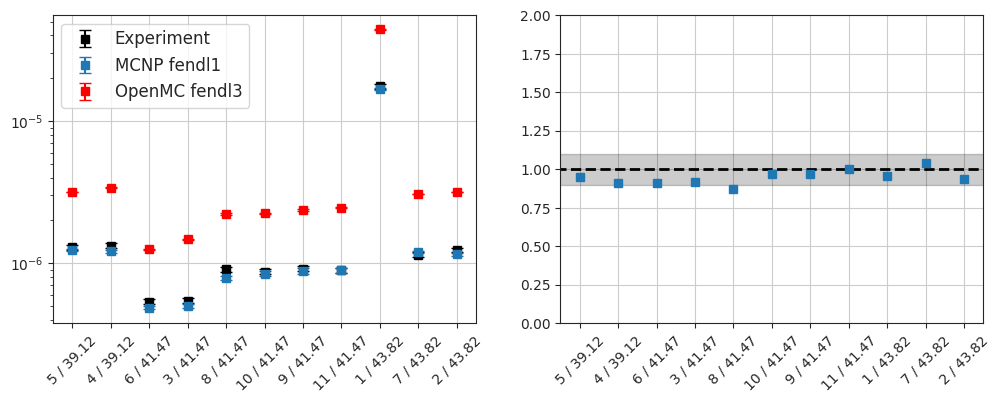

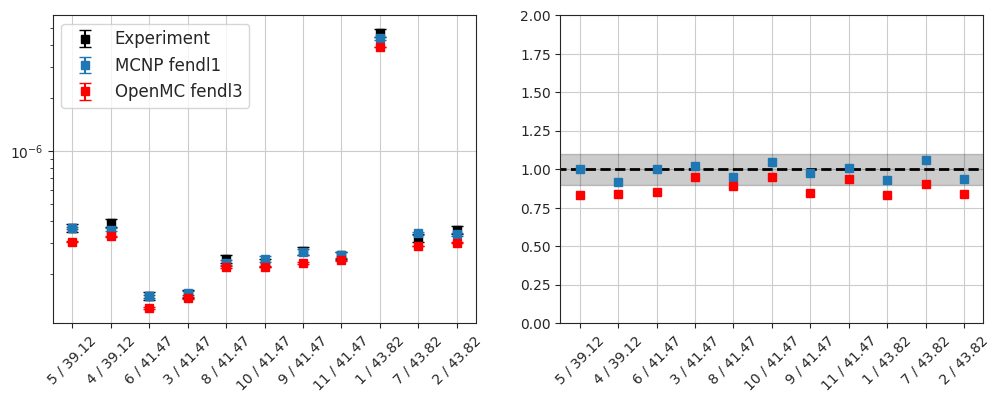

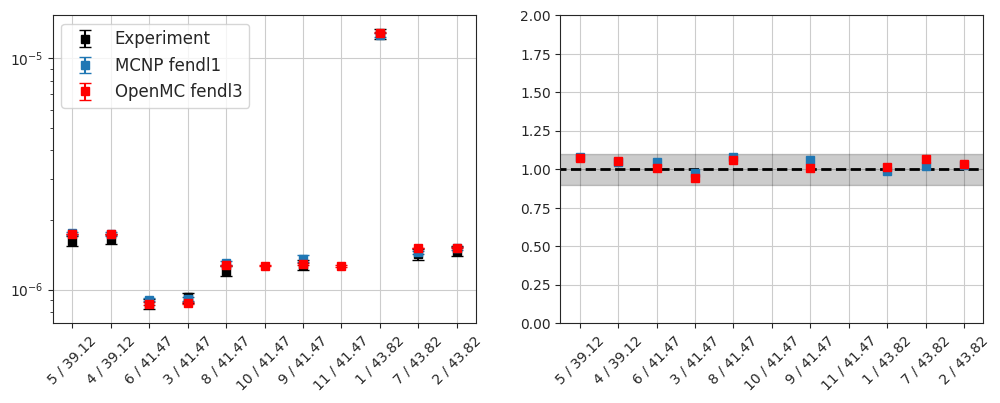

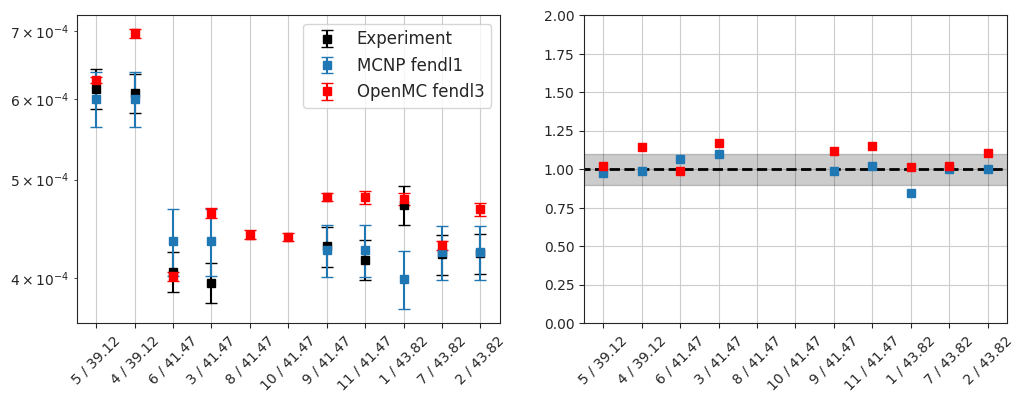

In [12]:
# Tables 6 and 10 results

# Nb93(n,2n)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax1.errorbar(np.arange(len(tab6_measured_nb)), tab6_measured_nb['E'], tab6_measured_nb['Error on E'], marker='s', ms=6, ls='none', capsize=4, color='k', label='Experiment')
ax1.errorbar(np.arange(len(tab10_computed_nb)), tab10_computed_nb['C FENDL-1'], tab10_computed_nb['FENDL-1 err'], marker='s', ms=6, ls='none', capsize=4, color='tab:blue', label='MCNP fendl1')
ax1.errorbar(np.arange(len(omc_tab10_nb)), omc_tab10_nb['mean']*tab10_nb_coeff, omc_tab10_nb['std. dev.']*tab10_nb_coeff, marker='s', ms=6, ls='none', capsize=4, color='red', label='OpenMC fendl3')
ax1.set_yscale('log')
ax1.set_xticks(np.arange(len(tab10_computed_nb)))
ax1.set_xticklabels(tab10_computed_nb['Position/y(cm)'])
ax1.tick_params(axis='x', labelrotation = 45)
ax1.legend(frameon=True, fontsize=12)
ax1.grid()
#
ax2.fill_between(np.arange(-1,20,1), 0.9*np.ones(21), 1.1*np.ones(21), step='pre', color='k', alpha=0.2)
ax2.hlines(1.0, -1, 20, colors='k', linestyles='--', linewidth=2)
ax2.plot(np.arange(len(tab10_computed_nb)), tab10_computed_nb['C/E FEN-1'], marker='s', ms=6, ls='none', color='tab:blue', label='MCNP fendl1')
ax2.plot(np.arange(len(omc_tab10_nb)), np.array(omc_tab10_nb['mean'])/np.array(tab6_measured_nb['E'])*tab10_nb_coeff, marker='s', ms=6, ls='none', color='red', label='OpenMC fendl3')
ax2.set_xlim([-0.5, 10.5])
ax2.set_ylim([0, 2])
ax2.set_xticks(np.arange(len(tab10_computed_nb)))
ax2.set_xticklabels(tab10_computed_nb['Position/y(cm)'])
ax2.tick_params(axis='x', labelrotation = 45)
ax2.grid()

# Al27(n,a)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax1.errorbar(np.arange(len(tab6_measured_al)), tab6_measured_al['E'], tab6_measured_al['Error on E'], marker='s', ms=6, ls='none', capsize=4, color='k', label='Experiment')
ax1.errorbar(np.arange(len(tab10_computed_al)), tab10_computed_al['C FENDL-1'], tab10_computed_al['FENDL-1 err'], marker='s', ms=6, ls='none', capsize=4, color='tab:blue', label='MCNP fendl1')
ax1.errorbar(np.arange(len(omc_tab10_al)), omc_tab10_al['mean']*tab10_al_coeff, omc_tab10_al['std. dev.']*tab10_al_coeff, marker='s', ms=6, ls='none', capsize=4, color='red', label='OpenMC fendl3')
ax1.set_yscale('log')
ax1.set_xticks(np.arange(len(tab10_computed_al)))
ax1.set_xticklabels(tab10_computed_al['Position/y(cm)'])
ax1.tick_params(axis='x', labelrotation = 45)
ax1.legend(frameon=True, fontsize=12)
ax1.grid()
#
ax2.fill_between(np.arange(-1,20,1), 0.9*np.ones(21), 1.1*np.ones(21), step='pre', color='k', alpha=0.2)
ax2.hlines(1.0, -1, 20, colors='k', linestyles='--', linewidth=2)
ax2.plot(np.arange(len(tab10_computed_al)), tab10_computed_al['C/E FEN-1'], marker='s', ms=6, ls='none', color='tab:blue', label='MCNP fendl1')
ax2.plot(np.arange(len(omc_tab10_al)), np.array(omc_tab10_al['mean'])/np.array(tab6_measured_al['E'])*tab10_al_coeff, marker='s', ms=6, ls='none', color='red', label='OpenMC fendl3')
ax2.set_xlim([-0.5, 10.5])
ax2.set_ylim([0, 2])
ax2.set_xticks(np.arange(len(tab10_computed_al)))
ax2.set_xticklabels(tab10_computed_al['Position/y(cm)'])
ax2.tick_params(axis='x', labelrotation = 45)
ax2.grid()

#  Ni58(n,p)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax1.errorbar(np.arange(len(tab6_measured_ni)), tab6_measured_ni['E'], tab6_measured_ni['Error on E'], marker='s', ms=6, ls='none', capsize=4, color='k', label='Experiment')
ax1.errorbar(np.arange(len(tab10_computed_ni)), tab10_computed_ni['C FENDL-1'], tab10_computed_ni['FENDL-1 err'], marker='s', ms=6, ls='none', capsize=4, color='tab:blue', label='MCNP fendl1')
ax1.errorbar(np.arange(len(omc_tab10_ni)), omc_tab10_ni['mean']*tab10_ni_coeff, omc_tab10_ni['std. dev.']*tab10_ni_coeff, marker='s', ms=6, ls='none', capsize=4, color='red', label='OpenMC fendl3')
ax1.set_yscale('log')
ax1.set_xticks(np.arange(len(tab10_computed_ni)))
ax1.set_xticklabels(tab10_computed_ni['Position/y(cm)'])
ax1.tick_params(axis='x', labelrotation = 45)
ax1.legend(frameon=True, fontsize=12)
ax1.grid()
#
ax2.fill_between(np.arange(-1,20,1), 0.9*np.ones(21), 1.1*np.ones(21), step='pre', color='k', alpha=0.2)
ax2.hlines(1.0, -1, 20, colors='k', linestyles='--', linewidth=2)
ax2.plot(np.arange(len(tab10_computed_ni)), tab10_computed_ni['C/E FEN-1'], marker='s', ms=6, ls='none', color='tab:blue', label='MCNP fendl1')
ax2.plot(np.arange(len(omc_tab10_ni)), np.array(omc_tab10_ni['mean'])/np.array(tab6_measured_ni['E'])*tab10_ni_coeff, marker='s', ms=6, ls='none', color='red', label='OpenMC fendl3')
ax2.set_xlim([-0.5, 10.5])
ax2.set_ylim([0, 2])
ax2.set_xticks(np.arange(len(tab10_computed_ni)))
ax2.set_xticklabels(tab10_computed_ni['Position/y(cm)'])
ax2.tick_params(axis='x', labelrotation = 45)
ax2.grid()

#  Au197(n,gamma)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax1.errorbar(np.arange(len(tab6_measured_au)), tab6_measured_au['E'], tab6_measured_au['Error on E'], marker='s', ms=6, ls='none', capsize=4, color='k', label='Experiment')
ax1.errorbar(np.arange(len(tab10_computed_au)), tab10_computed_au['C FENDL-1'], tab10_computed_au['FENDL-1 err'], marker='s', ms=6, ls='none', capsize=4, color='tab:blue', label='MCNP fendl1')
ax1.errorbar(np.arange(len(omc_tab10_au)), omc_tab10_au['mean']*tab10_au_coeff, omc_tab10_au['std. dev.']*tab10_au_coeff, marker='s', ms=6, ls='none', capsize=4, color='red', label='OpenMC fendl3')
ax1.set_yscale('log')
ax1.set_xticks(np.arange(len(tab10_computed_au)))
ax1.set_xticklabels(tab10_computed_au['Position/y(cm)'])
ax1.tick_params(axis='x', labelrotation = 45)
ax1.legend(frameon=True, fontsize=12)
ax1.grid()
#
ax2.fill_between(np.arange(-1,20,1), 0.9*np.ones(21), 1.1*np.ones(21), step='pre', color='k', alpha=0.2)
ax2.hlines(1.0, -1, 20, colors='k', linestyles='--', linewidth=2)
CoE_mcnp = plt.plot(np.arange(len(tab10_computed_au)), tab10_computed_au['C/E FEN-1'], marker='s', ms=6, ls='none', color='tab:blue', label='MCNP fendl1')
ax2.plot(np.arange(len(omc_tab10_au)), np.array(omc_tab10_au['mean'])/np.array(tab6_measured_au['E'])*tab10_au_coeff, marker='s', ms=6, ls='none', color='red', label='OpenMC fendl3')
ax2.set_xlim([-0.5, 10.5])
ax2.set_ylim([0, 2])
ax2.set_xticks(np.arange(len(tab10_computed_au)))
ax2.set_xticklabels(tab10_computed_au['Position/y(cm)'])
ax2.tick_params(axis='x', labelrotation = 45)
ax2.grid()

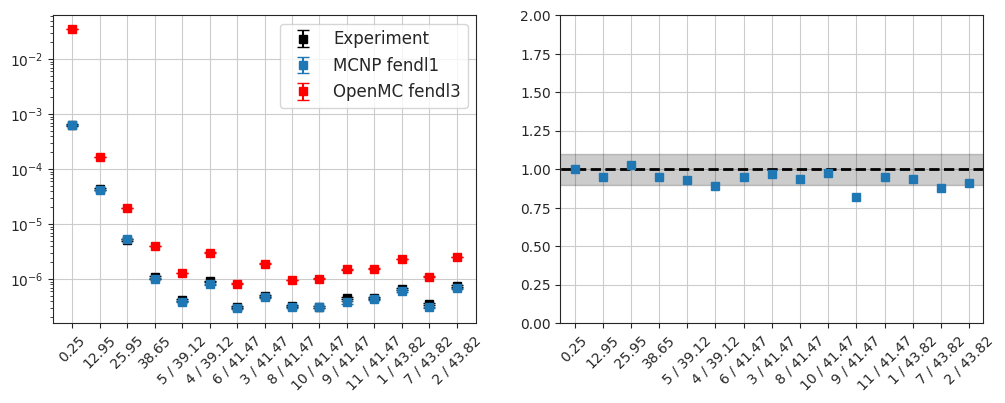

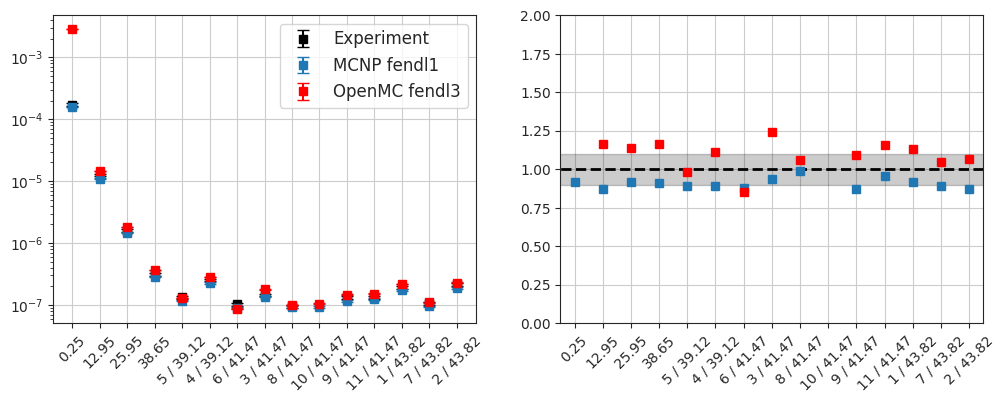

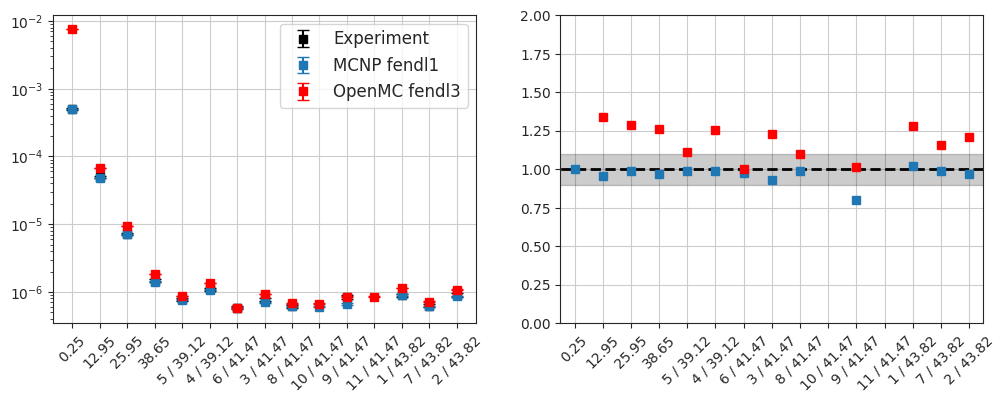

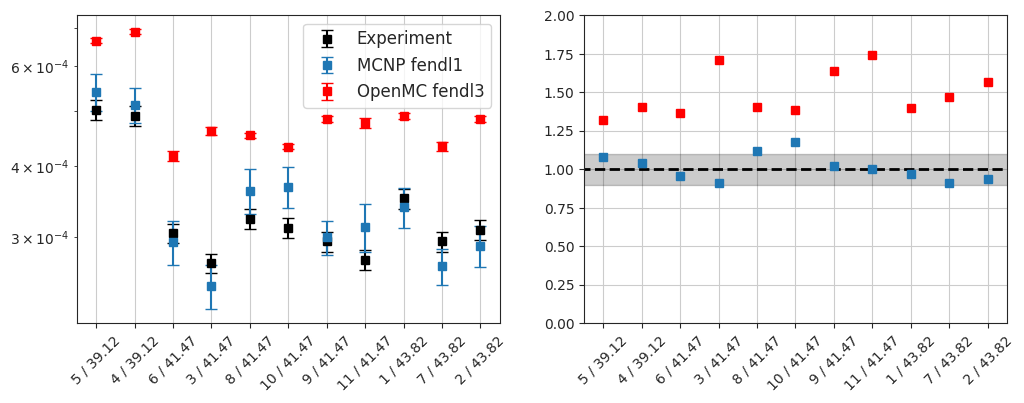

In [13]:
# Tables 7 and 11 results -  OFF-AXIS source

# Nb93(n,2n)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax1.errorbar(np.arange(len(tab7_measured_nb)), tab7_measured_nb['E'], tab7_measured_nb['Error on E'], marker='s', ms=6, ls='none', capsize=4, color='k', label='Experiment')
ax1.errorbar(np.arange(len(tab11_computed_nb)), tab11_computed_nb['C FENDL-1'], tab11_computed_nb['FENDL-1 err'], marker='s', ms=6, ls='none', capsize=4, color='tab:blue', label='MCNP fendl1')
ax1.errorbar(np.arange(len(omc_tab11_nb)), omc_tab11_nb['mean']*tab11_nb_coeff, omc_tab11_nb['std. dev.']*tab11_nb_coeff, marker='s', ms=6, ls='none', capsize=4, color='red', label='OpenMC fendl3')
ax1.set_yscale('log')
ax1.set_xticks(np.arange(len(tab11_computed_nb)))
ax1.set_xticklabels(tab11_computed_nb['Position/y(cm)'])
ax1.tick_params(axis='x', labelrotation = 45)
ax1.legend(frameon=True, fontsize=12)
ax1.grid()
#
ax2.fill_between(np.arange(-1,20,1), 0.9*np.ones(21), 1.1*np.ones(21), step='pre', color='k', alpha=0.2)
ax2.hlines(1.0, -1, 20, colors='k', linestyles='--', linewidth=2)
ax2.plot(np.arange(len(tab11_computed_nb)), tab11_computed_nb['C/E FEN-1'], marker='s', ms=6, ls='none', color='tab:blue', label='MCNP fendl1')
ax2.plot(np.arange(len(omc_tab11_nb)), np.array(omc_tab11_nb['mean'])/np.array(tab7_measured_nb['E'])*tab11_nb_coeff, marker='s', ms=6, ls='none', color='red', label='OpenMC fendl3')
ax2.set_xlim([-0.5, 14.5])
ax2.set_ylim([0, 2])
ax2.set_xticks(np.arange(len(tab11_computed_nb)))
ax2.set_xticklabels(tab11_computed_nb['Position/y(cm)'])
ax2.tick_params(axis='x', labelrotation = 45)
ax2.grid()

# Al27(n,a)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax1.errorbar(np.arange(len(tab7_measured_al)), tab7_measured_al['E'], tab7_measured_al['Error on E'], marker='s', ms=6, ls='none', capsize=4, color='k', label='Experiment')
ax1.errorbar(np.arange(len(tab11_computed_al)), tab11_computed_al['C FENDL-1'], tab11_computed_al['FENDL-1 err'], marker='s', ms=6, ls='none', capsize=4, color='tab:blue', label='MCNP fendl1')
ax1.errorbar(np.arange(len(omc_tab11_al)), omc_tab11_al['mean']*tab11_al_coeff, omc_tab11_al['std. dev.']*tab11_al_coeff, marker='s', ms=6, ls='none', capsize=4, color='red', label='OpenMC fendl3')
ax1.set_yscale('log')
ax1.set_xticks(np.arange(len(tab11_computed_al)))
ax1.set_xticklabels(tab11_computed_al['Position/y(cm)'])
ax1.tick_params(axis='x', labelrotation = 45)
ax1.legend(frameon=True, fontsize=12)
ax1.grid()
#
ax2.fill_between(np.arange(-1,20,1), 0.9*np.ones(21), 1.1*np.ones(21), step='pre', color='k', alpha=0.2)
ax2.hlines(1.0, -1, 20, colors='k', linestyles='--', linewidth=2)
ax2.plot(np.arange(len(tab11_computed_al)), tab11_computed_al['C/E FEN-1'], marker='s', ms=6, ls='none', color='tab:blue', label='MCNP fendl1')
ax2.plot(np.arange(len(omc_tab11_al)), np.array(omc_tab11_al['mean'])/np.array(tab7_measured_al['E'])*tab11_al_coeff, marker='s', ms=6, ls='none', color='red', label='OpenMC fendl3')
ax2.set_xlim([-0.5, 14.5])
ax2.set_ylim([0, 2])
ax2.set_xticks(np.arange(len(tab11_computed_al)))
ax2.set_xticklabels(tab11_computed_al['Position/y(cm)'])
ax2.tick_params(axis='x', labelrotation = 45)
ax2.grid()

#  Ni58(n,p)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax1.errorbar(np.arange(len(tab7_measured_ni)), tab7_measured_ni['E'], tab7_measured_ni['Error on E'], marker='s', ms=6, ls='none', capsize=4, color='k', label='Experiment')
ax1.errorbar(np.arange(len(tab11_computed_ni)), tab11_computed_ni['C FENDL-1'], tab11_computed_ni['FENDL-1 err'], marker='s', ms=6, ls='none', capsize=4, color='tab:blue', label='MCNP fendl1')
ax1.errorbar(np.arange(len(omc_tab11_ni)), omc_tab11_ni['mean']*tab11_ni_coeff, omc_tab11_ni['std. dev.']*tab11_ni_coeff, marker='s', ms=6, ls='none', capsize=4, color='red', label='OpenMC fendl3')
ax1.set_yscale('log')
ax1.set_xticks(np.arange(len(tab11_computed_ni)))
ax1.set_xticklabels(tab11_computed_ni['Position/y(cm)'])
ax1.tick_params(axis='x', labelrotation = 45)
ax1.legend(frameon=True, fontsize=12)
ax1.grid()
#
ax2.fill_between(np.arange(-1,20,1), 0.9*np.ones(21), 1.1*np.ones(21), step='pre', color='k', alpha=0.2)
ax2.hlines(1.0, -1, 20, colors='k', linestyles='--', linewidth=2)
ax2.plot(np.arange(len(tab11_computed_ni)), tab11_computed_ni['C/E FEN-1'], marker='s', ms=6, ls='none', color='tab:blue', label='MCNP fendl1')
ax2.plot(np.arange(len(omc_tab11_ni)), np.array(omc_tab11_ni['mean'])/np.array(tab7_measured_ni['E'])*tab11_ni_coeff, marker='s', ms=6, ls='none', color='red', label='OpenMC fendl3')
ax2.set_xlim([-0.5, 14.5])
ax2.set_ylim([0, 2])
ax2.set_xticks(np.arange(len(tab11_computed_ni)))
ax2.set_xticklabels(tab11_computed_ni['Position/y(cm)'])
ax2.tick_params(axis='x', labelrotation = 45)
ax2.grid()

#  Au197(n,gamma)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax1.errorbar(np.arange(len(tab7_measured_au)), tab7_measured_au['E'], tab7_measured_au['Error on E'], marker='s', ms=6, ls='none', capsize=4, color='k', label='Experiment')
ax1.errorbar(np.arange(len(tab11_computed_au)), tab11_computed_au['C FENDL-1'], tab11_computed_au['FENDL-1 err'], marker='s', ms=6, ls='none', capsize=4, color='tab:blue', label='MCNP fendl1')
ax1.errorbar(np.arange(len(omc_tab11_au)), omc_tab11_au['mean']*tab11_au_coeff, omc_tab11_au['std. dev.']*tab11_au_coeff, marker='s', ms=6, ls='none', capsize=4, color='red', label='OpenMC fendl3')
ax1.set_yscale('log')
ax1.set_xticks(np.arange(len(tab10_computed_au)))
ax1.set_xticklabels(tab10_computed_au['Position/y(cm)'])
ax1.tick_params(axis='x', labelrotation = 45)
ax1.legend(frameon=True, fontsize=12)
ax1.grid()
#
ax2.fill_between(np.arange(-1,20,1), 0.9*np.ones(21), 1.1*np.ones(21), step='pre', color='k', alpha=0.2)
ax2.hlines(1.0, -1, 20, colors='k', linestyles='--', linewidth=2)
CoE_mcnp = plt.plot(np.arange(len(tab11_computed_au)), tab11_computed_au['C/E FEN-1'], marker='s', ms=6, ls='none', color='tab:blue', label='MCNP fendl1')
ax2.plot(np.arange(len(omc_tab11_au)), np.array(omc_tab11_au['mean'])/np.array(tab7_measured_au['E'])*tab11_au_coeff, marker='s', ms=6, ls='none', color='red', label='OpenMC fendl3')
ax2.set_xlim([-0.5, 10.5])
ax2.set_ylim([0, 2])
ax2.set_xticks(np.arange(len(tab11_computed_au)))
ax2.set_xticklabels(tab11_computed_au['Position/y(cm)'])
ax2.tick_params(axis='x', labelrotation = 45)
ax2.grid()

In [14]:
# Dosimetric materials
# m131
al27 = openmc.Material(material_id=131, name='al27')
al27.add_element('Al', 1.0, 'ao')
al27.set_density('g/cm3', 2.7)
# al27.set_density('g/cm3', 1.2e-3)  # air density
# m281
ni58 = openmc.Material(material_id=281, name='ni58')
ni58.add_element('Ni', 1.0, 'ao')
ni58.set_density('g/cm3', 8.908)
# ni58.set_density('g/cm3', 1.2e-3)  # air density
# m411
nb93 = openmc.Material(material_id=411, name='nb93')
# nb93.add_nuclide('Nb93', 1.0, 'ao')
nb93.add_element('Nb', 1.0, 'ao')
nb93.set_density('g/cm3', 8.57)
# nb93.set_density('g/cm3', 1.2e-3)  # air density
# m791 Au-197(n,g)Au-198
au197 = openmc.Material(material_id=791, name='au197')
au197.add_element('Au', 1.0, 'ao')
au197.set_density('g/cm3', 19.3)
# au197.set_density('g/cm3', 1.2e-3)  # air density

act_foil = openmc.Material.mix_materials([nb93, al27, ni58, au197], [1, 0, 0, 0], 'vo')
act_foil_box = openmc.Material.mix_materials([nb93, al27, ni58, au197], [1, 0, 0, 0], 'vo')

print(nb93.get_nuclide_atom_densities())
print(act_foil.get_nuclide_atom_densities())

OrderedDict([('Nb93', 0.055550275570185104)])
OrderedDict([('Nb93', 0.055550275570185104), ('Al27', 0.0), ('Ni64', 0.0), ('Ni62', 0.0), ('Ni61', 0.0), ('Ni58', 0.0), ('Ni60', 0.0), ('Au197', 0.0)])


/home/segantin/openmc/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=131.
  warn(msg, IDWarning)
/home/segantin/openmc/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=281.
  warn(msg, IDWarning)
/home/segantin/openmc/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=411.
  warn(msg, IDWarning)
/home/segantin/openmc/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=791.
  warn(msg, IDWarning)


In [15]:
print(0.0033219025056786702 + 0.0010418590359672904 + 0.0008459906339953715 + 0.062221715418582 + 0.02396769338194039)

0.09139916097616373


In [16]:
# m33 Nb-93(n,2n)Nb-92m
nb93 = openmc.Material(material_id=33, name='nb93')
nb93.add_nuclide('Nb93', 1.0, 'ao')
nb93.set_density('g/cm3', 8.57)
# nb93.set_density('g/cm3', 1.2e-3)  # air density
# nb93.set_density('atom/b-cm', 6.146e-6)  # air atom density
# m34 In-115(n,n')In-115m
in115 = openmc.Material(material_id=34, name='in115')
in115.add_element('In', 1.0, 'ao')
in115.set_density('g/cm3', 7.31)
# in115.set_density('g/cm3', 1.2e-3)  # air density
# in115.set_density('atom/b-cm', 6.146e-6)  # air atom density
# m35 Au-197(n,g)Au-198
au197 = openmc.Material(material_id=35, name='au197')
au197.add_nuclide('Au197', 1.0, 'ao')
au197.set_density('g/cm3', 19.3)
# au197.set_density('g/cm3', 1.2e-3)  # air density
# au197.set_density('atom/b-cm', 6.146e-6)  # air atom density
# Xylene for the Ne213 liquid organic scintillator
xylene = openmc.Material(material_id=40, name='xylene')
xylene.add_element('H', 0.3333, 'ao')
xylene.add_element('C', 0.6667, 'ao')
xylene.set_density('g/cm3', 0.866)
# m6 air
air = openmc.Material(material_id=6, name='air')
air.add_element('N', 0.78, 'ao')
air.add_element('O', 0.22, 'ao')
air.add_element('Ar', 0.01, 'ao')
air.set_density('g/cm3', 1.225e-3)

# Mixed activation foil detector material
mixed_detector = openmc.Material.mix_materials([nb93, in115, au197, xylene, air], [0.0, 0.1, 0, 0.0, 0.9], 'vo')

print(mixed_detector.get_nuclide_atom_densities())

OrderedDict([('Nb93', 0.0), ('In113', 0.0001641354995513924), ('In115', 0.003669910273664968), ('Au197', 0.0), ('H1', 0.0), ('H2', 0.0), ('C13', 0.0), ('C12', 0.0), ('N14', 3.4758633938994576e-05), ('N15', 1.277889671050429e-07), ('O18', 1.9683456517819962e-08), ('O16', 9.816347581174496e-06), ('O17', 3.729269156295624e-09), ('Ar38', 2.8132769240944436e-10), ('Ar40', 4.454884389650889e-07), ('Ar36', 1.4920654719839529e-09)])


/home/segantin/openmc/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=6.
  warn(msg, IDWarning)


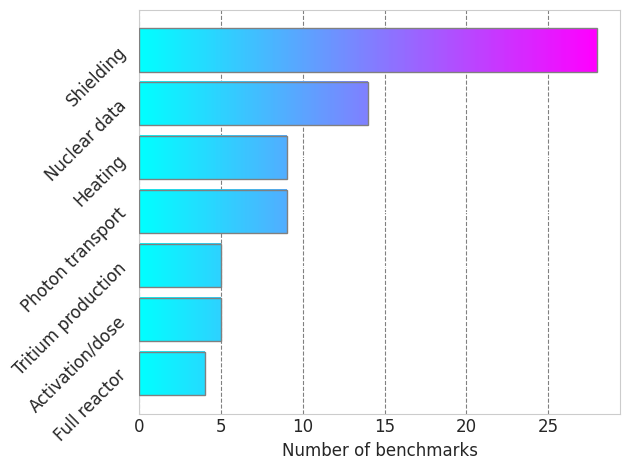

In [17]:
count = [28, 14, 9, 9, 5, 5, 4]
heads = ['Shielding', 'Nuclear data', 'Heating', 'Photon transport', 'Tritium production', 'Activation/dose', 'Full reactor']

import seaborn as sns

sns.set_style('whitegrid')

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import colors as mcolors, path

def gradientbars(bars, ydata):
    ax = bars[0].axes
    lim = ax.get_xlim()+ax.get_ylim()
    grad = np.atleast_2d(np.linspace(0,1,256))
    for bar in bars:
        bar.set_facecolor('none')
        x,y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.atleast_2d(np.linspace(0,1*w/max(ydata),256))
        ax.imshow(grad, extent=[x, x+w, y, y+h], aspect='auto', zorder=2, norm=cm.colors.NoNorm(vmin=0,vmax=1), cmap='cool')
    ax.axis(lim)

fig, ax = plt.subplots()
# zorder=0 sends gridlines to the back
ax.grid(which='major', axis='x', linestyle='--', color='gray', zorder=0)
ax.grid(which='major', axis='y', linestyle='-', color="white", zorder=0)
# zorder=3 makes our edges show
my_bar = ax.barh(heads, np.flip(count), edgecolor='gray', zorder=3)
gradientbars(my_bar, count)
ax.set_yticks(np.arange(len(heads)))
ax.set_yticklabels(np.flip(heads))
ax.set_xlabel('Number of benchmarks', fontsize=12)
ax.tick_params(axis='x', which='both', direction='in', labelsize=12)
ax.tick_params(axis='y', labelrotation =45, labelsize=12)
plt.tight_layout()
plt.savefig('n_benchmarks.png', format='png', dpi=600)

In [18]:
center = np.array((0,0,0))

center-(1.2,1.4,1.2)
# center+(1.2,0,1.5)

array([-1.2, -1.4, -1.2])

In [19]:
w9 = openmc.Material(material_id=200, name='w9')
w9.add_element('W', 0.056099119, 'ao')
w9.add_element('Ni', 0.005745912000000001, 'ao')
w9.add_element('Cu', 0.0035952, 'ao')
w9.set_density('atom/b-cm', 6.544e-02)

w10 = openmc.Material(material_id=300, name='w10')
w10.add_element('W', 0.055061373999999996, 'ao')
w10.add_element('Ni', 0.005639658, 'ao')
w10.add_element('Cu', 0.0035287, 'ao')
w10.set_density('atom/b-cm', 6.423e-02)

In [20]:
w10.get_mass_density()

17.73102174147258

In [29]:
heating_sp = openmc.StatePoint('statepoint.10.h5')

In [30]:
heating = heating_sp.get_tally(name='heating_dose').get_pandas_dataframe()
damage = heating_sp.get_tally(name='damage_dose').get_pandas_dataframe()

In [31]:
ev2gy = 1.60217733e-16
dens = 7.954 # 3.8
heating['mean'] = heating['mean']/0.255/2/dens*ev2gy
heating['std. dev.'] = heating['std. dev.']/0.255/2/dens*ev2gy
damage['mean'] = damage['mean']/0.255/2/dens*ev2gy
damage['std. dev.'] = damage['std. dev.']/0.255/2/dens*ev2gy

In [ ]:
# m999 - CaF2 nuclear heating dosimeter TLD-300
caf2 = openmc.Material(material_id=999, name='caf2')
caf2.add_element('Ca', 1.0, 'ao')
caf2.add_element('F', 2.0, 'ao')
caf2.set_density('g/cm3', 3.18)

caf2.get_nuclide_atom_densities

/home/segantin/openmc/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=999.
  warn(msg, IDWarning)


<bound method Material.get_nuclide_atom_densities of Material
	ID             =	999
	Name           =	caf2
	Temperature    =	None
	Density        =	3.18 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	Ca44           =	0.02086      [ao]
	Ca46           =	4e-05        [ao]
	Ca42           =	0.00647      [ao]
	Ca48           =	0.00187      [ao]
	Ca40           =	0.96941      [ao]
	Ca43           =	0.00135      [ao]
	F19            =	2.0          [ao]
>